In [24]:
import sys, cv2, glob, os, time
import pandas as pd
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten,Activation,LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
print(os.listdir("E:/New folder"))
%matplotlib inline


['sample_submission.csv', 'test', 'train', 'train.csv']


In [25]:
train_dir ="E:/New folder/train"
test_dir = "E:/New folder/test"
train_df = pd.read_csv("E:/New folder/train.csv")
train_df.tail()

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


In [37]:
img_rows = 32
img_cols = 32
channels = 3
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [38]:
def generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    model.add(Reshape(img_shape))
    z = Input(shape=(z_dim,))
    img = model(z)
    return Model(z, img)
def discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    img = Input(shape=img_shape)
    prediction = model(img)
    return Model(img, prediction)

discriminator = discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(),metrics=['accuracy'])
generator = generator(img_shape, z_dim)
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
prediction = discriminator(img)
combined = Model(z, prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

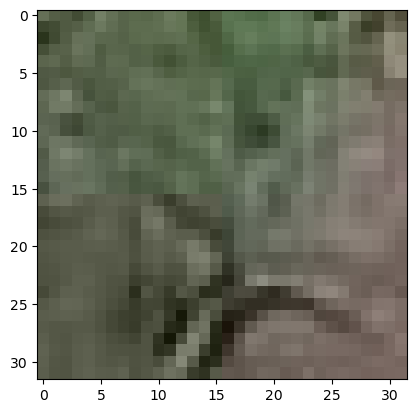

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("E:/New folder/train/0d45a6e65ef98becf8d906dd91b2bc75.jpg")
plt.imshow(img)
plt.show()


In [49]:
def prepareTrainSet(train_df):
    train_1 = train_df[train_df.has_cactus == 1]
    train_0 = train_df[train_df.has_cactus == 0]
    ids_1 = train_1.id.tolist()
    ids_0 = train_0.id.tolist()
    path = glob.glob("E:/New folder/train/*fff43acb3b7a23edcc4ae937be2b7522.jpg")
    imgs_0, imgs_1 = [], []
    for img in path:
        im = cv2.imread(img)
        if img.split("\\")[-1] in ids_1:
            imgs_1.append(im)
        elif img.split("\\")[-1] in ids_0:
            imgs_0.append(im)
    X_train_0 = np.asarray(imgs_0)
    X_train_1 = np.asarray(imgs_1)
    X_train_0 = X_train_0 / 127.5 - 1.
    X_train_1 = X_train_1 / 127.5 - 1
    print(X_train_0.shape)
    print(X_train_1.shape)
    return X_train_0, X_train_1
losses = []
accuracies = []

def train(iterations, batch_size, sample_interval):
    gen_images = []
    X_train_0, X_train_1 = prepareTrainSet(train_df)
    X_train = X_train_0
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        g_loss = combined.train_on_batch(z, real)
        if iteration % sample_interval == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration,d_loss[0], 100 * d_loss[1], g_loss))
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])
            gen_images.append(sample_images(iteration))
            
            
    return gen_images

In [50]:
def sample_images(iteration, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1,(image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns,figsize=(10,10), sharey=True, sharex=True)
    
    
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0],)
            axs[i,j].axis('off')
            cnt += 1
            
            
            
    return gen_imgs

In [51]:
import warnings; warnings.simplefilter('ignore')

(1, 32, 32, 3)
(0,)
4/4 [==============================] - 0s 27ms/step
0 [D loss: 0.759487, acc.: 22.66%] [G loss: 1.195681]
4/4 [==============================] - 0s 10ms/step


4/4 [==============================] - 0s 12ms/step


4/4 [==============================] - 0s 10ms/step


4/4 [==============================] - 0s 19ms/step


4/4 [==============================] - 0s 8ms/step


4/4 [==============================] - 1s 10ms/step


4/4 [==============================] - 0s 10ms/step


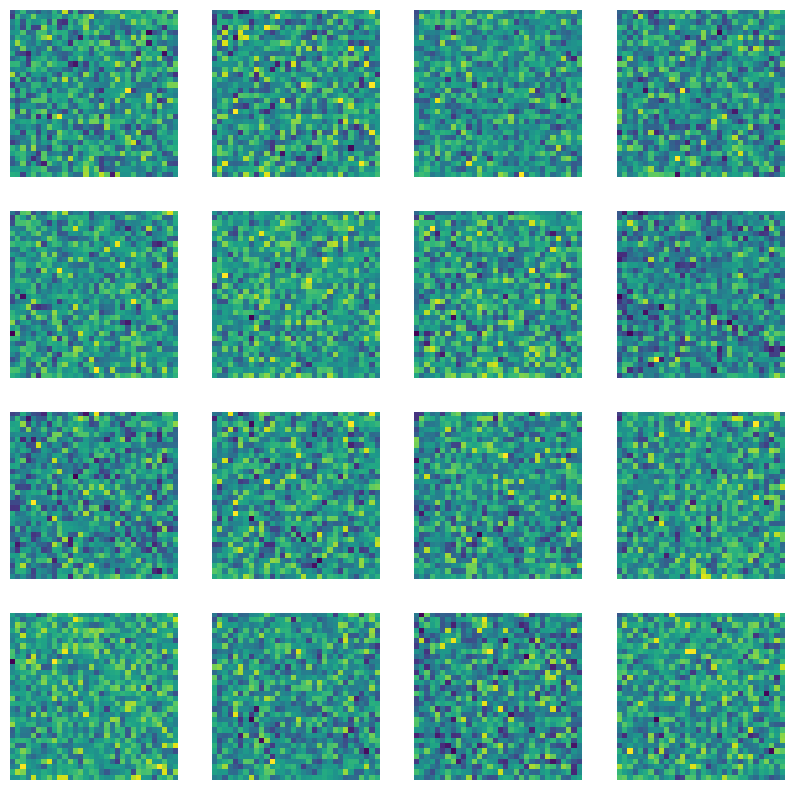

In [52]:
iterations = 1000
batch_size = 128
sample_interval = 1000
gen_imgs = train(iterations, batch_size, sample_interval)


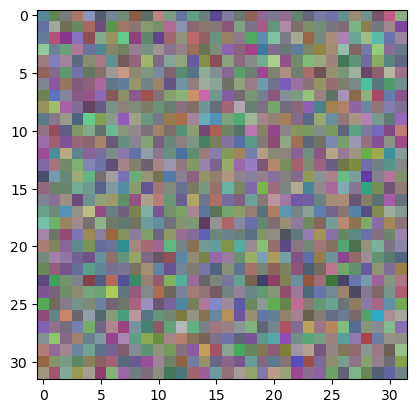

In [53]:
row = -1
col = -1
plt.imshow(gen_imgs[row][col])